In [1]:
#Import library
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from sklearn import datasets 
import sklearn.linear_model 
from sklearn.preprocessing import OneHotEncoder 
from sklearn.metrics import accuracy_score
import urllib.request as request
import csv

In [12]:
#Standardize input data
def stand_norm(df,cols):
    stats= df.describe()
    for col in cols:
        def func(x):
            return (x-stats[col][1])/stats[col][2]
        df[col] = df[col].apply(func)
    return df 
#Add polynominal 
def add_poly(df,cols,n_degree=2):
    for col in cols:
        df[col+'_poly_'+str(n_degree)] = df[col]**n_degree
    return df 
#Define cost functon
def costFunc(X,y,beta,lmbda,length):
    sq_diff = np.sum((X.dot(beta)- y)**2)
    cost = (1/(2*(length))) * (sq_diff + (lmbda * np.sum(beta[1:]**2)))
    return cost
def compute_cost(X,y,params,lmbda):
    n_samples = len(y)
    h = X @ params
    sq_diff = np.sum((h-y)**2)
    cost = (1/(2*n_samples))* (sq_diff + (lmbda*np.sum(params)**2))
    return cost 
#Define gradient Desc: 
def gradient_descent(X,y,params,lmbda,learning_rate,n_iters):
    n_samples = len(y)
    J_history = np.zeros((n_iters,1))
    for i in range(n_iters):
        params = params*(1-(learning_rate*lmbda)/n_samples) - (learning_rate/n_samples) * X.T @ (X@params - y)
        J_history[i] = compute_cost(X,y,params,lmbda)
    return (J_history,params)

#Define gradient Desc_no ridge: 
def gradient_descent_normal(X,y,params,learning_rate,n_iters):
    n_samples = len(y)
    J_history = np.zeros((n_iters,1))
    for i in range(n_iters):
        params = params - (learning_rate/n_samples) * X.T @ (X @ params - y) 
        J_history[i] = compute_cost(X,y,params,0)
    return (J_history,params)

In [88]:
#Import data 
#Get data 
boston = datasets.load_boston()
boston_data = pd.DataFrame(data= np.c_[boston['data'], boston['target']],\
                     columns= np.append (boston['feature_names'].astype(object), ['target']))
#Get dummy
boston_data = pd.concat([boston_data, pd.get_dummies(boston_data['RAD'],prefix = 'RAD_')], axis=1)
print(boston_data.head(2))
print(boston_data.columns)
#Standardize
boston_data= stand_norm(boston_data,['CRIM','ZN','INDUS', 'NOX','RM','AGE','DIS','TAX','PTRATIO','B','LSTAT'])
#Add poly
boston_data = add_poly(boston_data,['CRIM','ZN','INDUS','NOX','RM','AGE','DIS','TAX','PTRATIO','B','LSTAT'])
#Get X and y 
y = boston_data[['target']]
X = boston_data.drop(['target','RAD','RAD__1.0'], axis = 1)
X.shape, y.shape

      CRIM    ZN  INDUS  CHAS    NOX     RM   AGE     DIS  RAD    TAX  \
0  0.00632  18.0   2.31   0.0  0.538  6.575  65.2  4.0900  1.0  296.0   
1  0.02731   0.0   7.07   0.0  0.469  6.421  78.9  4.9671  2.0  242.0   

     ...      target  RAD__1.0  RAD__2.0  RAD__3.0  RAD__4.0  RAD__5.0  \
0    ...        24.0         1         0         0         0         0   
1    ...        21.6         0         1         0         0         0   

   RAD__6.0  RAD__7.0  RAD__8.0  RAD__24.0  
0         0         0         0          0  
1         0         0         0          0  

[2 rows x 23 columns]
Index(['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX',
       'PTRATIO', 'B', 'LSTAT', 'target', 'RAD__1.0', 'RAD__2.0', 'RAD__3.0',
       'RAD__4.0', 'RAD__5.0', 'RAD__6.0', 'RAD__7.0', 'RAD__8.0',
       'RAD__24.0'],
      dtype='object')


((506, 31), (506, 1))

In [4]:
#print heatmap 
boston_data.corr()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,...,ZN_poly_2,INDUS_poly_2,NOX_poly_2,RM_poly_2,AGE_poly_2,DIS_poly_2,TAX_poly_2,PTRATIO_poly_2,B_poly_2,LSTAT_poly_2
CRIM,1.000000,-0.199458,0.404471,-0.055295,0.417521,-0.219940,0.350784,-0.377904,0.622029,0.579564,...,-0.129232,0.017631,0.091128,0.090826,-0.050495,-0.019587,0.532380,-0.075692,0.368232,0.326909
ZN,-0.199458,1.000000,-0.533828,-0.042697,-0.516604,0.311991,-0.569537,0.664408,-0.311948,-0.314563,...,0.907446,0.169226,0.107934,0.041219,0.398412,0.557134,-0.242129,0.238350,-0.138315,-0.021090
INDUS,0.404471,-0.533828,1.000000,0.062938,0.763651,-0.391676,0.644779,-0.708027,0.595129,0.720760,...,-0.385981,0.335914,0.220943,-0.015765,-0.171762,-0.241826,0.522537,-0.041083,0.279597,0.206903
CHAS,-0.055295,-0.042697,0.062938,1.000000,0.091203,0.091251,0.086518,-0.099176,-0.007368,-0.035587,...,-0.038235,-0.066199,0.123898,0.086914,-0.081536,-0.090524,-0.014693,0.020600,-0.057260,-0.018612
NOX,0.417521,-0.516604,0.763651,0.091203,1.000000,-0.302188,0.731470,-0.769230,0.611441,0.668023,...,-0.388540,0.165365,0.524207,0.093688,-0.274835,-0.241405,0.459999,0.201216,0.299238,0.230810
RM,-0.219940,0.311991,-0.391676,0.091251,-0.302188,1.000000,-0.240265,0.205246,-0.209847,-0.292048,...,0.242691,0.019534,-0.133829,0.204796,0.055945,0.008727,-0.157437,0.226037,-0.076561,-0.222110
AGE,0.350784,-0.569537,0.644779,0.086518,0.731470,-0.240265,1.000000,-0.747881,0.456022,0.506456,...,-0.446613,0.151801,0.091505,0.100323,-0.588428,-0.299098,0.368953,0.123010,0.212171,0.184486
DIS,-0.377904,0.664408,-0.708027,-0.099176,-0.769230,0.205246,-0.747881,1.000000,-0.494588,-0.534432,...,0.520651,-0.104875,-0.080073,-0.149174,0.381110,0.641702,-0.427425,-0.079371,-0.237528,-0.199176
RAD,0.622029,-0.311948,0.595129,-0.007368,0.611441,-0.209847,0.456022,-0.494588,1.000000,0.910228,...,-0.221946,-0.021577,0.129686,0.069118,-0.145950,-0.096734,0.828821,-0.162829,0.409051,0.228696
TAX,0.579564,-0.314563,0.720760,-0.035587,0.668023,-0.292048,0.506456,-0.534432,0.910228,1.000000,...,-0.197195,0.146352,0.184198,0.029879,-0.114905,-0.063865,0.721542,-0.092098,0.387831,0.230436


In [77]:
#Initialize
params = np.ones((31,1))
cost = compute_cost(X,y,params,0.01)
print("This is initial cost :", cost)
print("This is initial params :", np.array(params).T)
#Gradient 
cost, params = gradient_descent(X.values,y.values,params,0.01,0.01,1000)
print("This is final cost :", cost[-1])
print("This is final params :", np.array(params).T)

This is initial cost : 0         0.009496
target    0.009496
dtype: float64
This is initial params : [[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 1. 1. 1.]]
This is final cost : [13.64017905]
This is final params : [[-3.91767051 -5.00297034 -1.58768746  3.27164275 -4.78537768  1.54686398
   1.82970905 -2.80021779 -2.00198995  0.0540006   4.18977073 -5.84043106
   0.74511662  1.77193903  3.73399678  4.37063318  4.93728287  2.3729672
   3.58927406  3.83132151  0.31593937  1.12193642  0.88787384  1.46771361
   1.02523413  1.97855658  0.91792943  5.42366086  2.30250084  1.24416252
   1.26660445]]


[13.63176626]
[13.7157844]


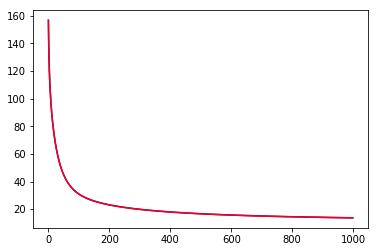

In [90]:
#Number of iterations:
n_iterations = 1000
learning_rate = 0.01
lmbda = 0.1
#Ridge 
params = np.ones((31,1))
cost = compute_cost(X.values,y.values,params,0.01)
cost, params = gradient_descent(X.values,y.values,params,lmbda,learning_rate,n_iterations)
#Normal 
params_OlS= np.ones((31,1))
cost_OLS = compute_cost(X.values,y.values,params,0.01)
cost_OLS, params_OLS = gradient_descent(X.values,y.values,params_OlS,0,learning_rate,n_iterations )
#Compare 
plt.plot(range(len(cost)),cost,'b')
plt.plot(range(len(cost_OLS)),cost_OLS,'r')
print(cost_OLS[-1])
print(cost[-1])

In [93]:
# Prediction
predictions = X.values  @ params
predictions_OLS = X.values  @ params_OLS
residual  = X.values @ params - y.values
residual = [(abs(a)/b)*100 for a,b in zip(residual,y.values)]
cost = sum(residual)/len(residual)
print('mape :', cost)

mape : [19.22167557]


<BarContainer object of 31 artists>

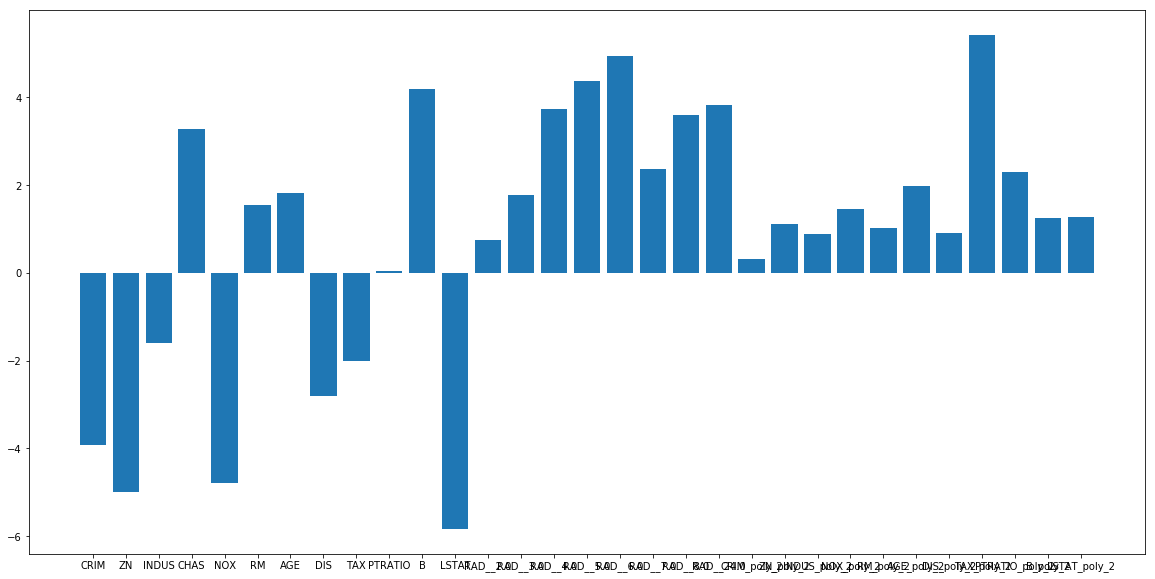

In [109]:
#Plot 
fig= plt.figure(figsize=(20, 10))
plt.bar(X.columns,np.concatenate(params_OLS, axis=0))

In [111]:
pd.DataFrame([np.concatenate(params_OLS, axis=0),np.concatenate(params, axis=0),X.columns]).T

,0,1,2
0,-3.91778,-3.91672,CRIM
1,-5.00313,-5.00153,ZN
2,-1.58763,-1.58823,INDUS
3,3.27193,3.26909,CHAS
4,-4.78558,-4.78352,NOX
5,1.54684,1.54711,RM
6,1.82986,1.82837,AGE
7,-2.80034,-2.79908,DIS
8,-2.00195,-2.00239,TAX
9,0.053945,0.0545006,PTRATIO
